### Segmentation for dog-cat dataset

In [1]:
# import libs
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

#### Dataset - data preprocessing

In [2]:
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader

In [3]:
img_size = (128, 128)
# Resize to smaller images for testing
# img_size = (64, 64)
number_classes = 3

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    # the mean and standard deviation for each channel (Red, Green, and Blue)
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.299, 0.224, 0.225))
])

def target_transform(target):
  img = transforms.Resize(img_size)(target)      # Resize the target mask to the same size
  img = transforms.functional.pil_to_tensor(img).squeeze_()  # Convert the mask to tensor and remove extra dimension
  img = img - 1                                    # Adjust pixel values (for class labels)

  img = img.to(torch.long)                        # Change tensor type to long (for classification tasks)
  return img


In [4]:
train_set = OxfordIIITPet(root='pets_data', split='trainval', target_types='segmentation',
                          transform=transform,
                          target_transform=target_transform,
                          download=True)

test_set = OxfordIIITPet(root='pets_data', split='test', target_types='segmentation',
                         transform=transform,
                         target_transform=target_transform,
                         download=True)

# batch_size = 64
batch_size = 32

train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(test_set,
                         batch_size=batch_size,
                         num_workers=2)

100%|██████████| 792M/792M [00:21<00:00, 36.3MB/s]


Extracting pets_data/oxford-iiit-pet/images.tar.gz to pets_data/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:01<00:00, 16.6MB/s]


Extracting pets_data/oxford-iiit-pet/annotations.tar.gz to pets_data/oxford-iiit-pet


In [5]:
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Testing dataset size: {len(test_loader.dataset)}")


Training dataset size: 3680
Testing dataset size: 3669


In [ ]:
from torch.utils.data import Subset
import numpy as np

# Reduce training dataset to 50%
train_indices = np.random.choice(len(train_set), size=int(0.5 * len(train_set)), replace=False)
train_subset = Subset(train_set, train_indices)

# Reduce testing dataset to 50%
test_indices = np.random.choice(len(test_set), size=int(0.5 * len(test_set)), replace=False)
test_subset = Subset(test_set, test_indices)


# Use these subsets in DataLoader
# train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Testing dataset size: {len(test_loader.dataset)}")


Training dataset size: 3680
Testing dataset size: 3669


#### Dataset - post-processed data

In [6]:
# de-normalize
def de_normalize(img,
                 mean=(0.485, 0.456, 0.406),
                 std=(0.299, 0.224, 0.225)):
    result = img * std + mean
    result = np.clip(result, 0.0, 1.0)

    return result

#### Build Model



In [7]:
# Convolutional Block
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels) -> None:
    super().__init__()
    self.conv_block = nn.Sequential (
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    x = self.conv_block(x)
    return x


In [8]:
# Encoder Block
class Encoder(nn.Module):
  def __init__(self, in_channels, out_channels) -> None:
    super().__init__()
    self.encoder = nn.Sequential(
        nn.MaxPool2d(2),
        ConvBlock(in_channels, out_channels)
    )

  def forward(self, x):
    x = self.encoder(x)
    return x


In [9]:
# Decoder Block
class Decoder(nn.Module):
  def __init__(self, in_channels, out_channels) -> None:
    super().__init__()
    self.conv_trans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
    self.conv_block = ConvBlock(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.conv_trans(x1)
    x = torch.cat([x2, x1], dim=1)
    x = self.conv_block(x)

    return x


In [10]:
# Build Model

class UNet(nn.Module):
  def __init__(self, n_channels, n_classes) -> None:
    super().__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes

    self.in_conv = ConvBlock(n_channels, 64)

    self.enc_1 = Encoder(64, 128)
    self.enc_2 = Encoder(128, 256)
    self.enc_3 = Encoder(256, 512)
    self.enc_4 = Encoder(512, 1024)

    self.dec_1 = Decoder(1024, 512)
    self.dec_2 = Decoder(512, 256)
    self.dec_3 = Decoder(256, 128)
    self.dec_4 = Decoder(128, 64)

    self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)

  def forward(self, x):
    x1 = self.in_conv(x)
    x2 = self.enc_1(x1)
    x3 = self.enc_2(x2)
    x4 = self.enc_3(x3)
    x5 = self.enc_4(x4)
    x = self.dec_1(x5, x4)
    x = self.dec_2(x, x3)
    x = self.dec_3(x, x2)
    x = self.dec_4(x, x1)
    x = self.out_conv(x)
    return x


#### Train and Evaluate Model

In [11]:
@torch.inference_mode()
def display_prediction(model, image, target):
    model.eval()
    img = image[None, ...].to(device)
    output = model(img)
    pred = torch.argmax(output, axis=1)

    plt.figure(figsize=(10, 5))

    # Input Image
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.title('Input Image')
    plt.imshow(de_normalize(image.numpy().transpose(1, 2, 0)))

    # Prediction
    plt.subplot(1, 3, 2)  # Change here
    plt.axis('off')
    plt.title('Prediction')
    plt.imshow(pred[0].cpu().numpy())

    # Ground Truth
    plt.subplot(1, 3, 3)  # Change here
    plt.axis('off')
    plt.title('Ground Truth')
    plt.imshow(target)

    plt.show()


In [12]:
# evaluate function

def evaluate(model, test_loader, criterion):
  model.eval()
  test_loss = 0.0
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      test_loss += loss.item()

  test_loss = test_loss / len(test_loader)
  return test_loss


In [13]:
# params for model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_epoch = 30
learning_rate = 0.001


In [ ]:
# Make sure you have enough resources to train this model,
# it was really time consuming for me
import time
import torch
import copy

# Parameters for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# max_epoch = 30
# to learn / test only
max_epoch = 1
learning_rate = 0.001
# Reduce if memory runs out
# batch_size = 16
train_losses = []
test_losses = []

# Instantiate the model, loss, and optimizer
model = UNet(n_channels=3, n_classes=number_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()  # You can add class weights if needed
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Store the best weights
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

# Training loop
start_time = time.time()
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0

    # Training
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Evaluation
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    # Save the best model
    if test_loss < best_loss:
        best_loss = test_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    # Print progress
    print(f"Epoch [{epoch + 1}/{max_epoch}] - Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

# Save training time
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

# Load best weights
model.load_state_dict(best_model_wts)

# Save the trained model
torch.save(best_model_wts, 'best_model_unet.pth')
print("Best model weights saved.")


Epoch [1/1] - Train Loss: 0.8790, Test Loss: 6.3850
Training completed in 545.59 seconds.
Best model weights saved.


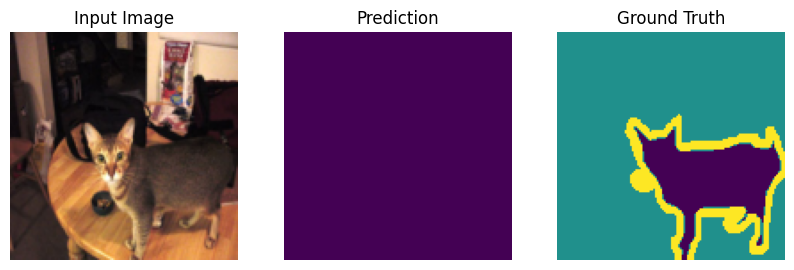

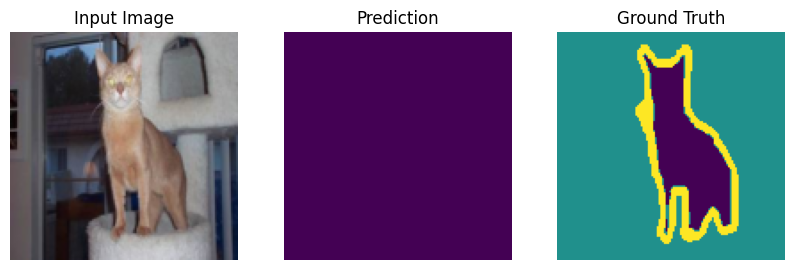

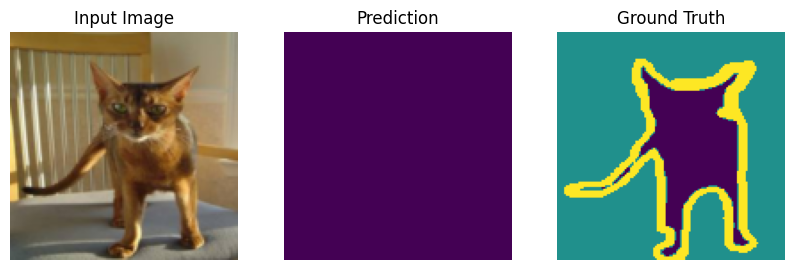

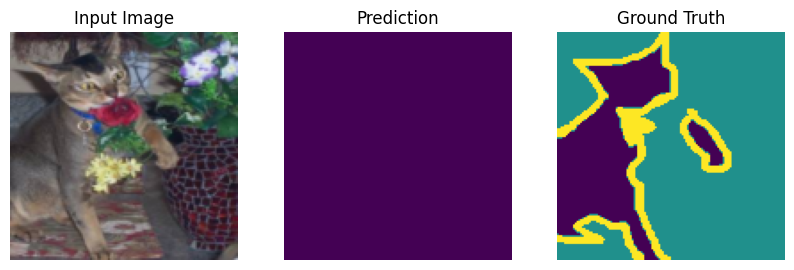

In [15]:
# Evaluate a few test points / doesn't trainning - just see Ground Truth
model = UNet(n_channels=3, n_classes=3)

n_test_points = 4
for i in range(n_test_points):
    img, gt = test_set[i]
    display_prediction(model, img, gt)
    
